In [124]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [126]:
#Weight Distribution Function
def create_dist(weights):
    range = np.arange(0,weights+1)
    probability_mean_sd = st.norm.cdf(range, loc=range.mean(), scale=range.std())
    return(np.diff(probability_mean_sd))

In [128]:
symbol = "GC=F" #Gold Commodity in Dec, 2024
ticker = yf.Ticker(symbol)
data = ticker.history(period='1y')
variable_windows = [2,3,5,10,25,50]

In [130]:
#Creating columns for various averages
for window in variable_windows:
    data[f'{window}-SMA'] = data['Close'].rolling(window=window).mean()
#print(data.head())

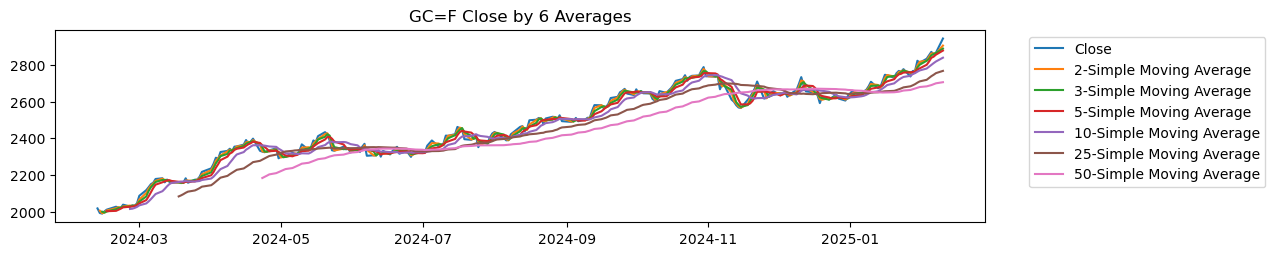

In [132]:
#Plotting Basic Variable Moving Averages
plt.figure(figsize=(12, 2.5))
plt.plot(data['Close'], label='Close')
for window in variable_windows:
    plt.plot(data[f'{window}-SMA'], label = f'{window}-Simple Moving Average')
plt.title(f'{symbol} Close by {len(variable_windows)} Averages')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [134]:
#Simple Weighted Average
#Creating columns for various averages
for window in variable_windows:
    weights = create_dist(window)
    data[f'{window}-WMA'] = data['Close'].rolling(window=window).apply(lambda prices: np.dot(weights, prices)/weights.sum(), raw=True)
#print(data.head())

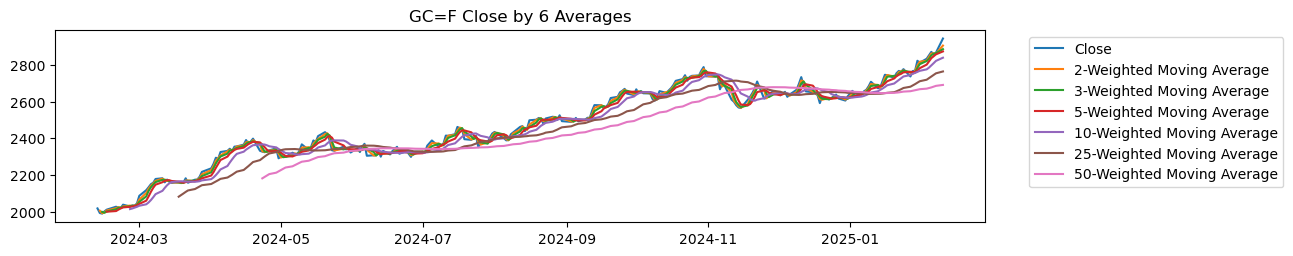

In [136]:
#Plotting Weighted Variable Moving Averages
plt.figure(figsize=(12, 2.5))
plt.plot(data['Close'], label='Close')
for window in variable_windows:
    plt.plot(data[f'{window}-WMA'], label = f'{window}-Weighted Moving Average')
plt.title(f'{symbol} Close by {len(variable_windows)} Averages')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

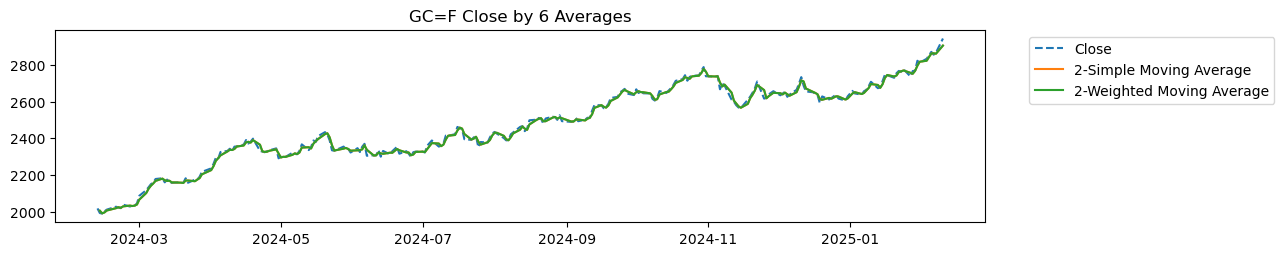

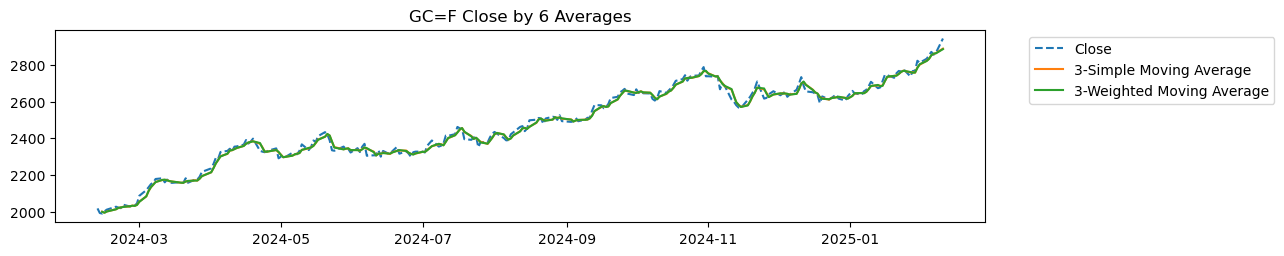

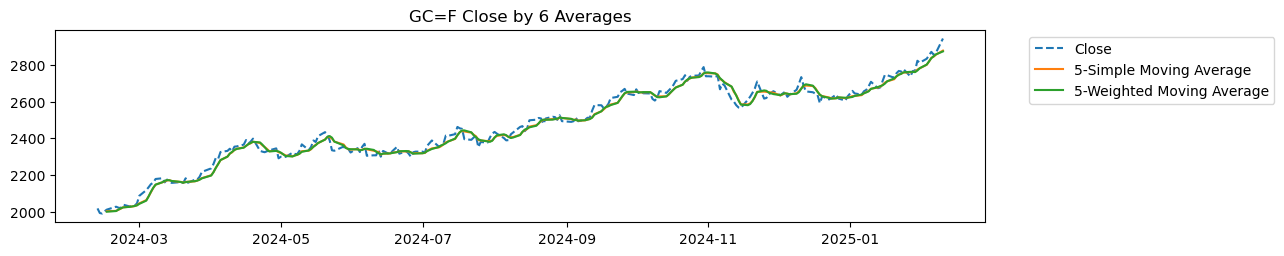

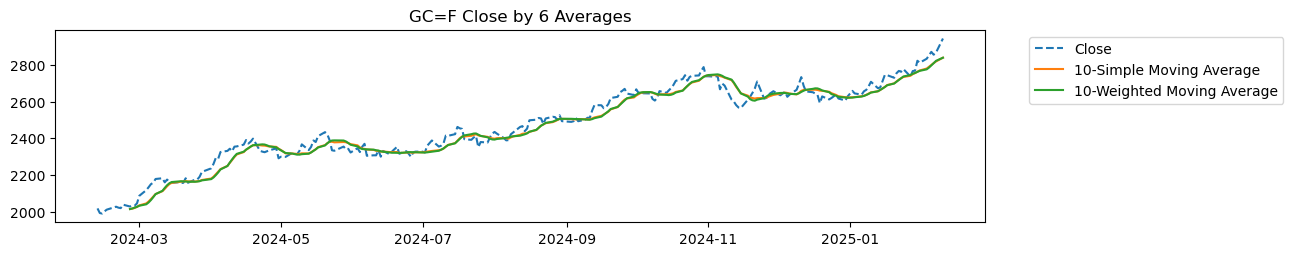

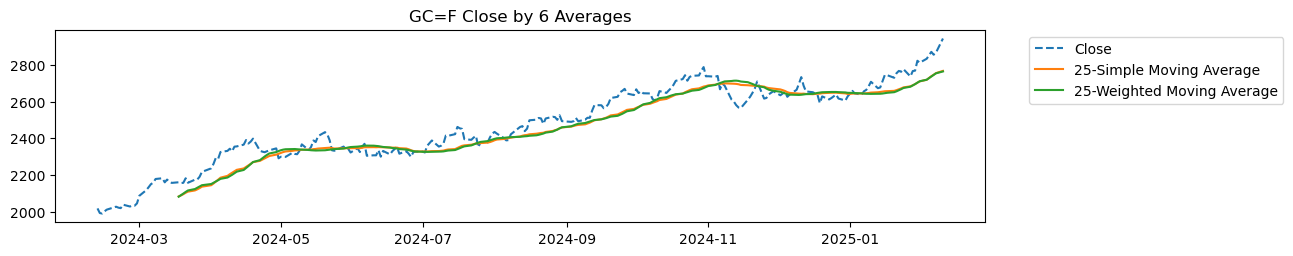

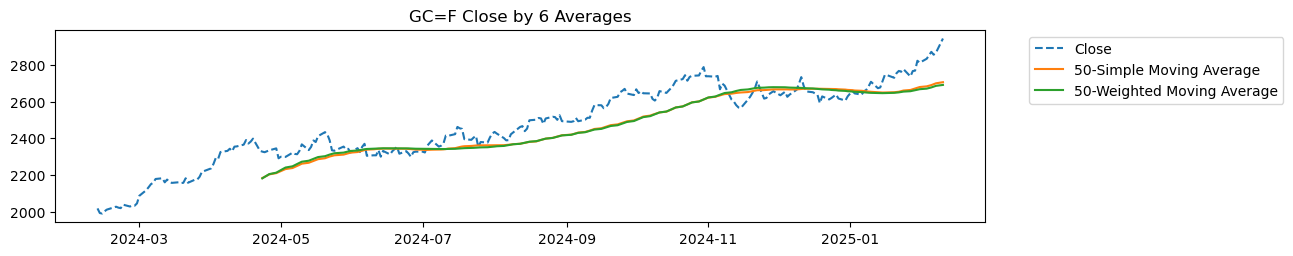

In [138]:
#Plotting Weighted Variable Moving Averages
for window in variable_windows:
    plt.figure(figsize=(12, 2.5))
    plt.plot(data['Close'], label='Close', linestyle='--')
    plt.plot(data[f'{window}-SMA'], label = f'{window}-Simple Moving Average')
    plt.plot(data[f'{window}-WMA'], label = f'{window}-Weighted Moving Average')
    plt.title(f'{symbol} Close by {len(variable_windows)} Averages')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

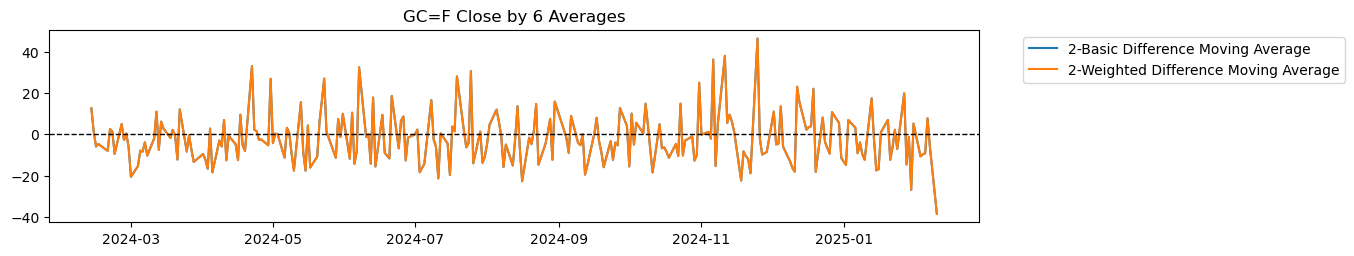

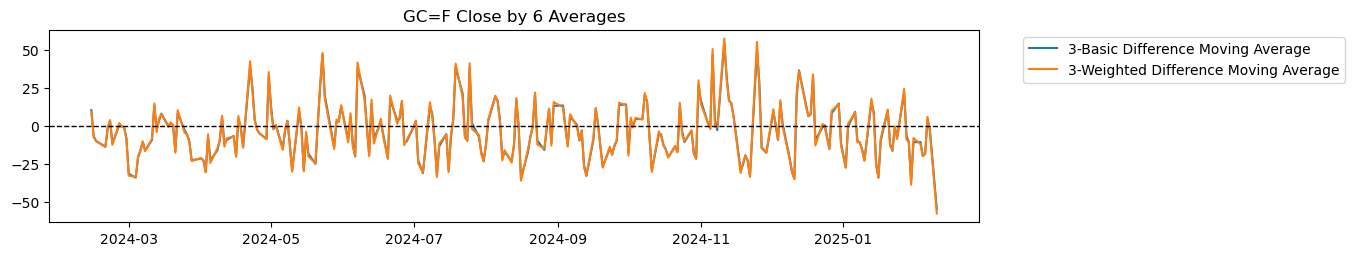

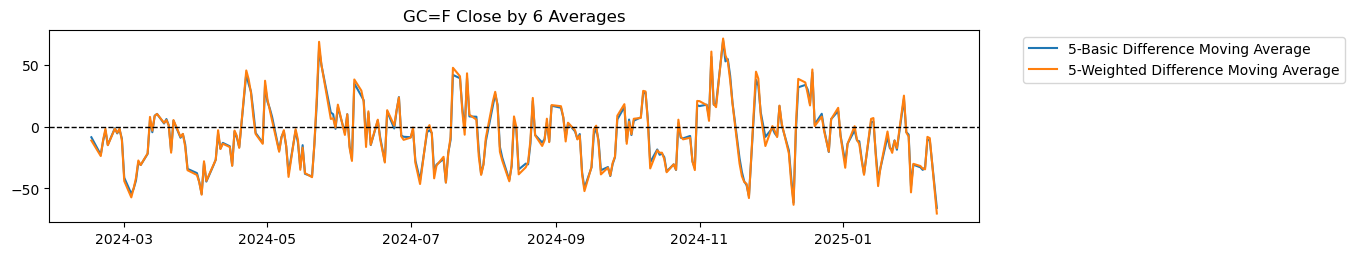

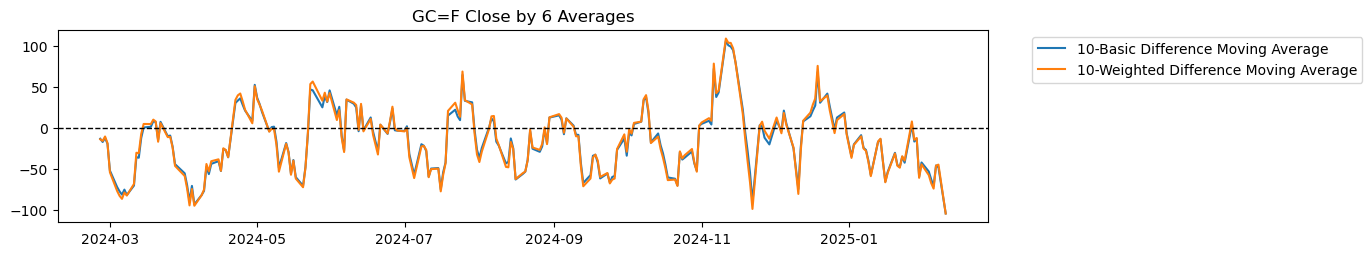

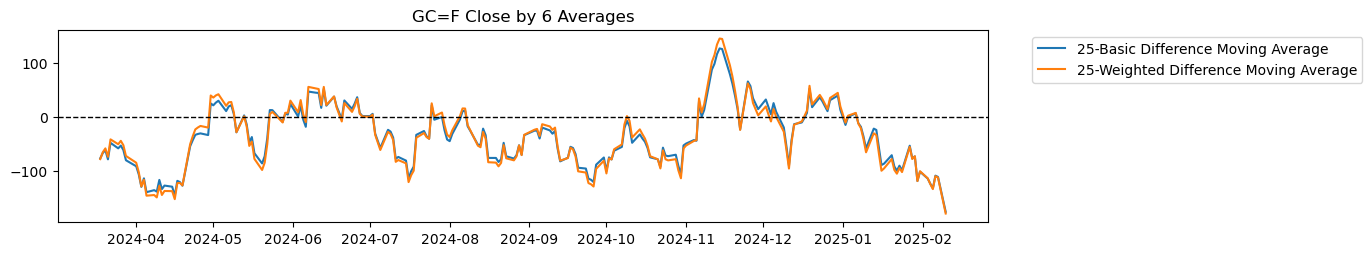

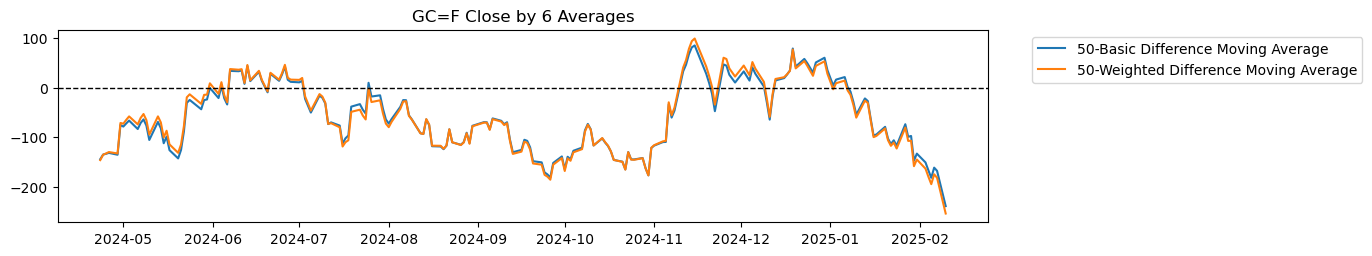

In [139]:
#Differences in Averages
for window in variable_windows:
    plt.figure(figsize=(12, 2.5))
    data[f'{window}-WMA-Residual'] = data[f'{window}-WMA'] - data[f'Close']
    data[f'{window}-SMA-Residual'] = data[f'{window}-SMA'] - data[f'Close']
    plt.plot(data[f'{window}-SMA-Residual'], label = f'{window}-Basic Difference Moving Average')
    plt.plot(data[f'{window}-WMA-Residual'], label = f'{window}-Weighted Difference Moving Average')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0
    plt.title(f'{symbol} Close by {len(variable_windows)} Averages')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

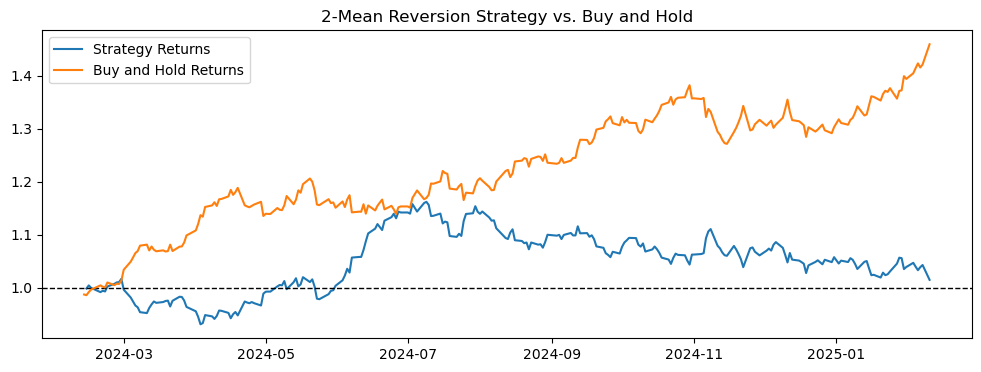

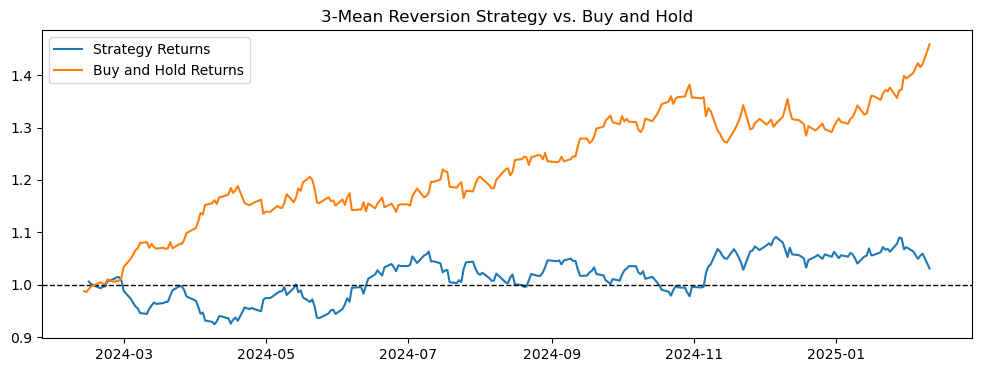

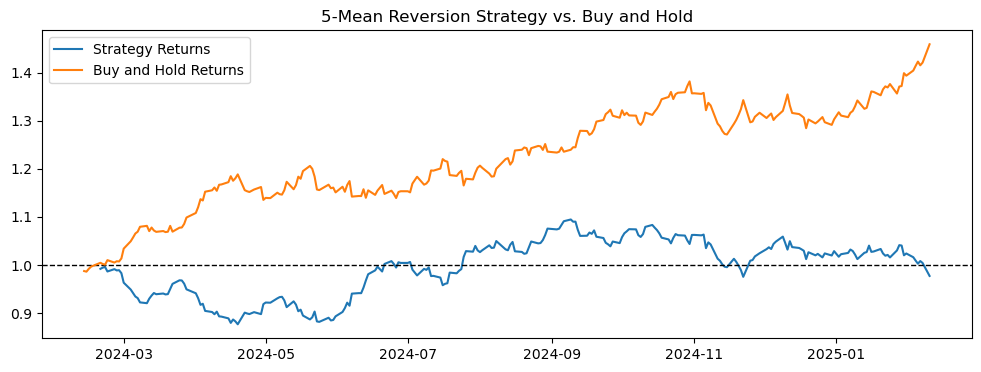

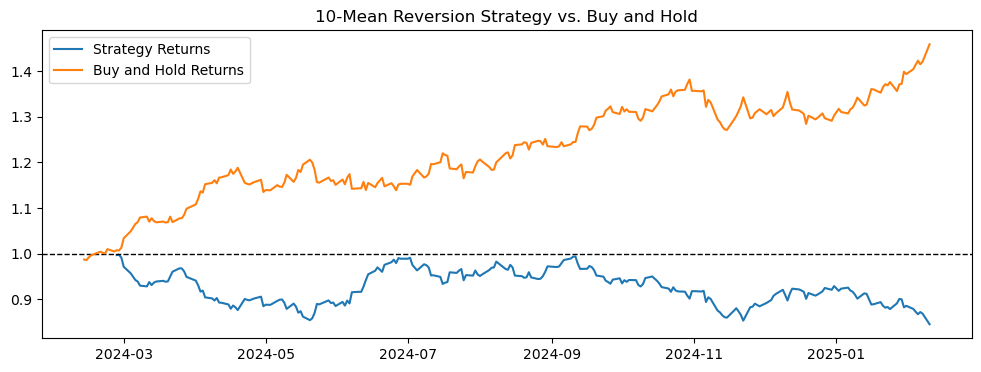

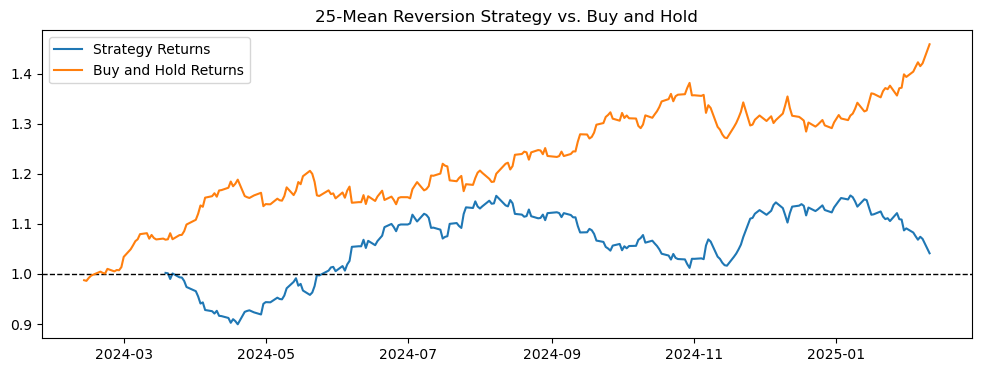

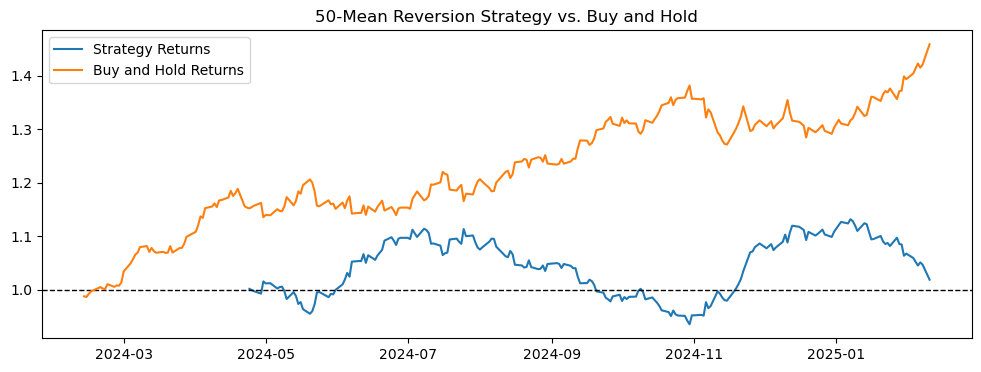

In [140]:
#Creating a trading strategy

margin = 0
#Baseline Cumulative Returns
data['Cumulative Returns'] = (1 + data['Close'].pct_change()).cumprod()
data['Signal']= 0  # Initialize signal column

for window in variable_windows:
    buy_condition = data[f'Close'] + margin < data[f'{window}-WMA']
    sell_condition = data[f'Close'] + margin > data[f'{window}-WMA']
    
    data.loc[buy_condition, f'{window}-Signal'] = 1  # Buy signal
    data.loc[sell_condition, f'{window}-Signal'] = -1  # Sell signal

    # Backtest: calculate strategy returns
    data[f'{window}-Strategy Return'] = data[f'{window}-Signal'].shift(1) * data['Close'].pct_change()

    plt.figure(figsize=(12, 4))
    plt.plot((1 + data[f'{window}-Strategy Return']).cumprod(), label='Strategy Returns')
    plt.axhline(y=1, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0
    plt.plot(data['Cumulative Returns'], label='Buy and Hold Returns')
    plt.title(f'{window}-Mean Reversion Strategy vs. Buy and Hold')
    plt.legend()

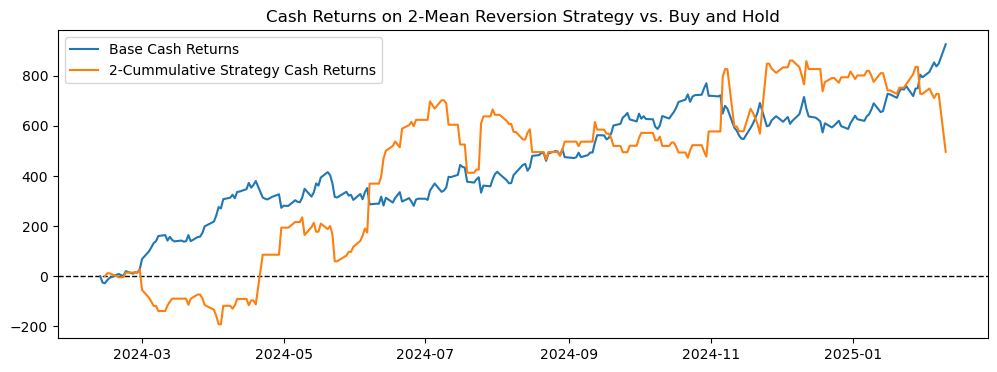

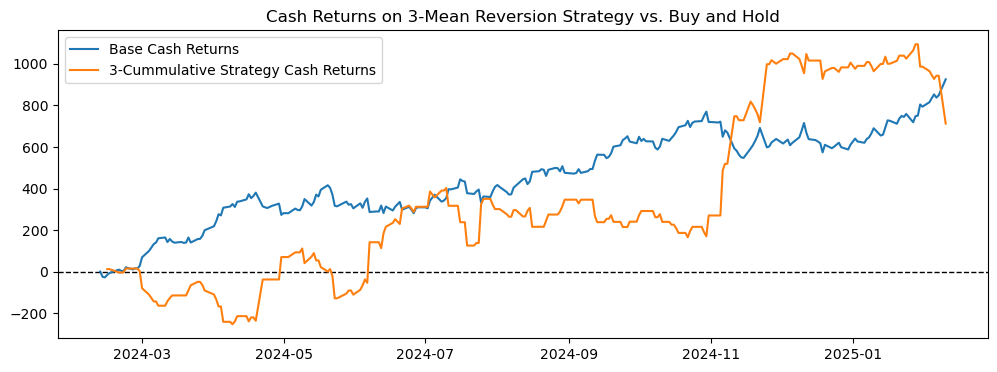

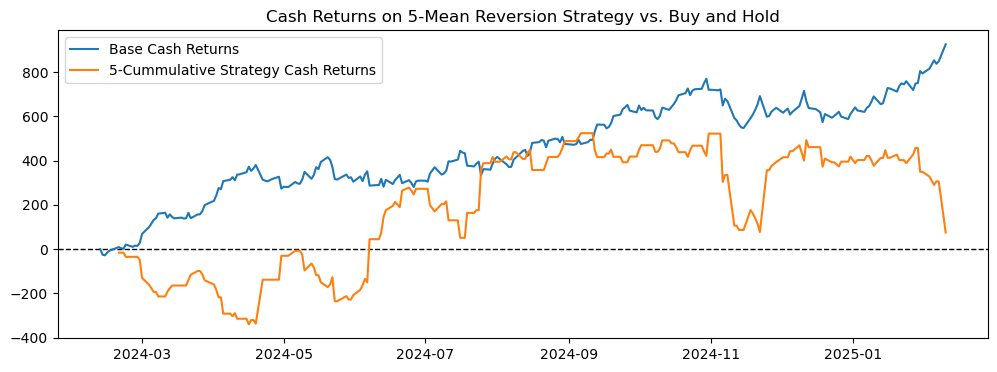

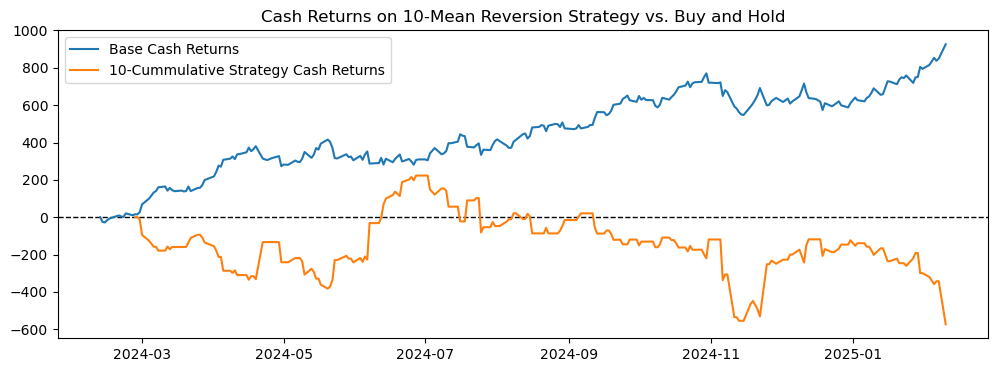

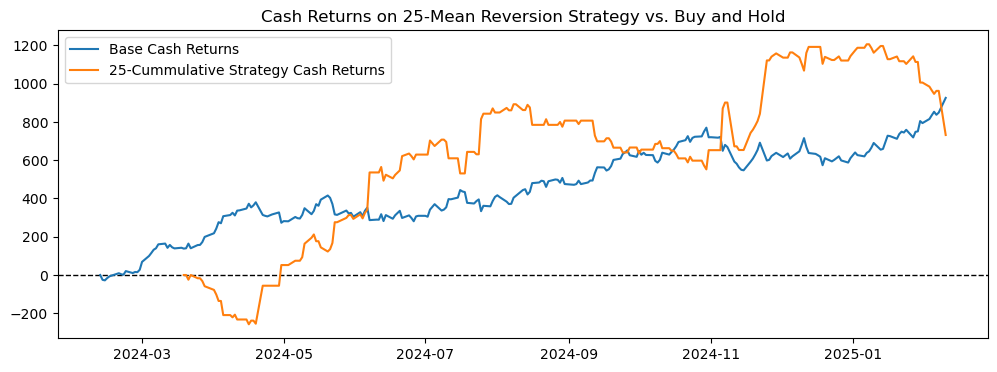

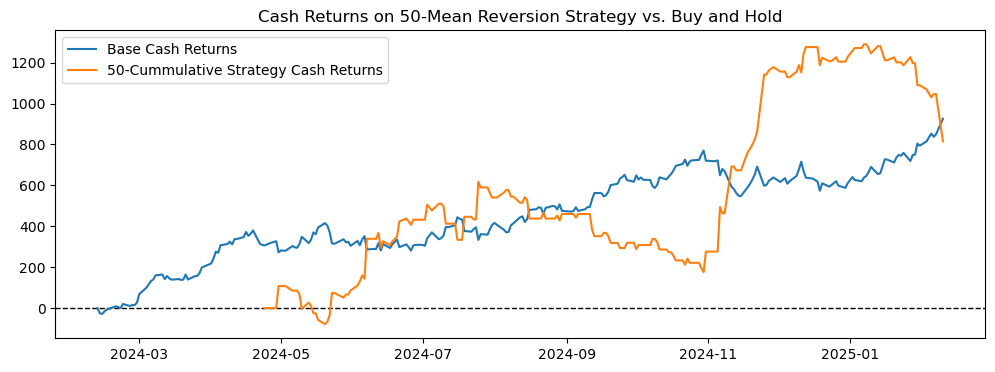

In [141]:
#Cash Returns
data['Base Cash Return'] = data['Close'] - data['Close'].iloc[0]
scale = 100
modifier = round(abs(data['Close'].pct_change()) * scale)
for window in variable_windows:
    plt.figure(figsize=(12, 4))
    data[f'{window}-Cash Returns'] = np.concatenate(([0.0], np.diff(data['Close']))) * data[f'{window}-Signal'].shift(1) * modifier
    #print(data[f'{window}-Cash Returns'])
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0
    plt.plot(data['Base Cash Return'], label='Base Cash Returns')
    plt.plot(data[f'{window}-Cash Returns'].cumsum(), label=f'{window}-Cummulative Strategy Cash Returns')
    plt.title(f'Cash Returns on {window}-Mean Reversion Strategy vs. Buy and Hold')
    plt.legend()

In [143]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = np.array(returns) - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns, ddof=1)

for window in variable_windows:
    # Daily returns of a strategy
    returns = data[f'{window}-Strategy Return'].dropna().tolist()
    
    # Compute Sharpe Ratio based on Current 10-Year Treasury Rate
    sharpe = sharpe_ratio(returns, risk_free_rate=0.0449)
    print(f"Sharpe Ratio: {sharpe:.2f}")

Sharpe Ratio: -4.57
Sharpe Ratio: -4.56
Sharpe Ratio: -4.57
Sharpe Ratio: -4.61
Sharpe Ratio: -4.47
Sharpe Ratio: -4.47


<BarContainer object of 13 artists>

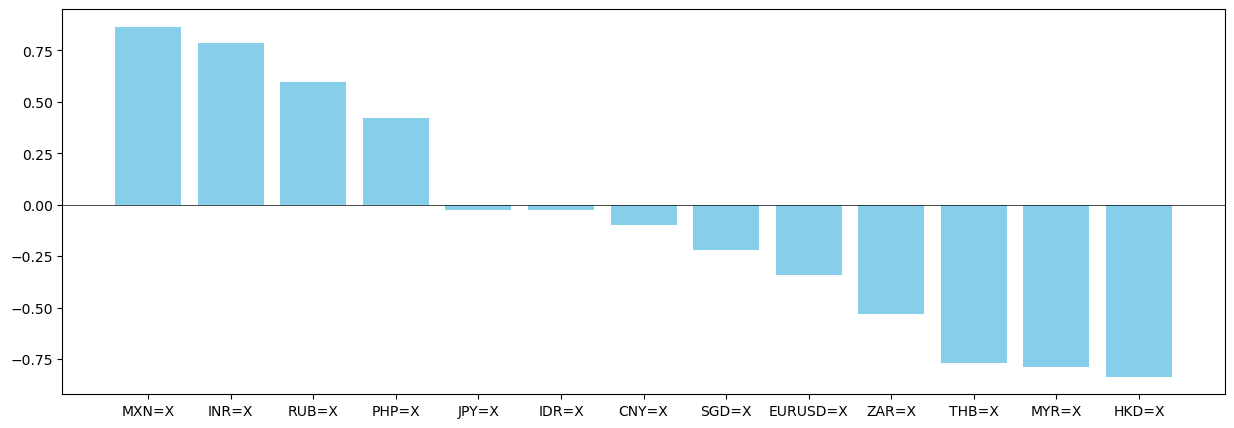

In [144]:
tickers = ["EURUSD=X","RUB=X", "CNY=X", "INR=X", "MXN=X", "SGD=X", "PHP=X", "IDR=X", "JPY=X", "HKD=X", "THB=X", "SGD=X", "MYR=X", "ZAR=X"] #Gold Commodity in Dec, 2024

# Compute correlations after fixing the timestamps
metal_corrs = {
    ticker: yf.Ticker(ticker).history(period='1y')['Close']
    .tz_localize(None)  # Remove timezone info
    .rename(lambda x: x.normalize())  # Normalize timestamps
    .corr(data['Close'].tz_localize(None))  # Make sure both are timezone-naive
    for ticker in tickers
}
metal_corrs = {k: v for k, v in sorted(metal_corrs.items(), key=lambda item: item[1], reverse=True)}
labels = list(metal_corrs.keys())
values = list(metal_corrs.values())

# Create bar plot
plt.figure(figsize=(15, 5))
plt.axhline(y=0, color='black', linewidth=0.5)  # Horizontal line at y=0
plt.bar(labels, values, color='skyblue')

C:\Users\kprsa\AppData\Local\Temp\ipykernel_44252\768425426.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  comp_df[f'{country}-Strategy Return'] = comp_df[f'{country}-Signal'].shift(1) * comp_df[f'{country}'].pct_change()
C:\Users\kprsa\AppData\Local\Temp\ipykernel_44252\768425426.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  comp_df[f'{country}-Cumulative Returns'] = (1 + comp_df[f'{country}'].pct_change()).cumprod()
C:\Users\kprsa\AppData\Local\Temp\ipykernel_44252\768425426.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed 

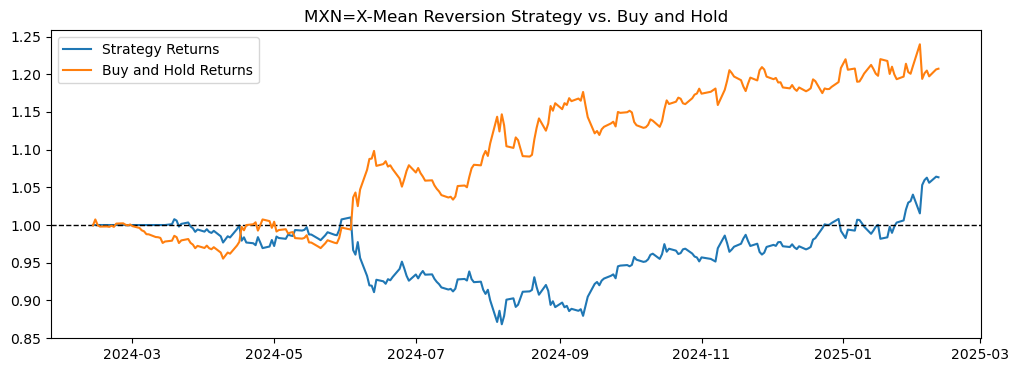

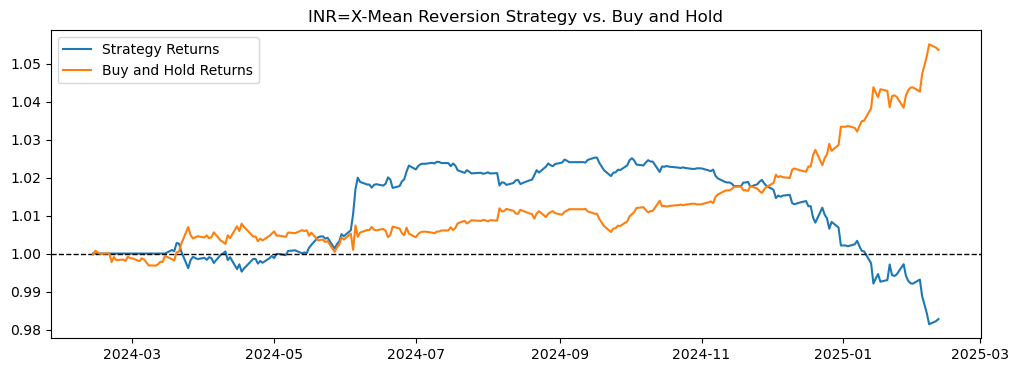

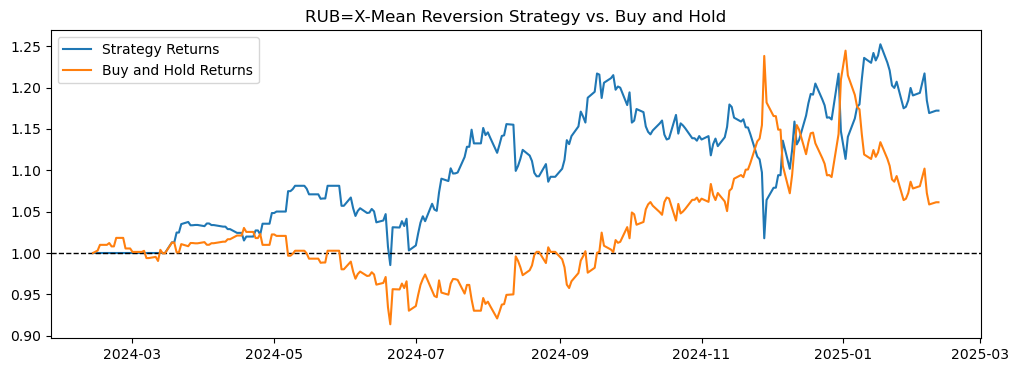

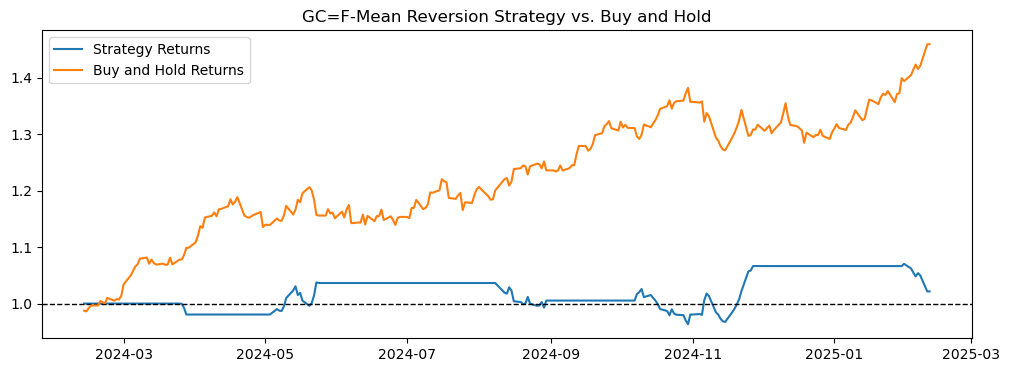

In [145]:
#Non-Working Test
top_countries = ["MXN=X", "INR=X", "RUB=X", "GC=F"]

comp_df = pd.DataFrame()

margin = 0
day_range = 25

for country in top_countries:
    comp_df[f"{country}"] = yf.Ticker(country).history(period='1y')['Close'].tz_localize(None).rename(lambda x: x.normalize())  # Normalize timestamps
    weights = create_dist(day_range)
    comp_df[f'{country}-WMA'] = comp_df[f"{country}"].rolling(window=day_range).apply(lambda prices: np.dot(weights, prices)/weights.sum(), raw=True)
    comp_df[f"{country}-Signal"] = 0

    buy_condition = comp_df[f'{country}'] + margin < comp_df[f'{country}-WMA']
    sell_condition = comp_df[f'{country}'] + margin > comp_df[f'{country}-WMA']
    
    comp_df.loc[buy_condition, f'{country}-Signal'] = 1  # Buy signal
    comp_df.loc[sell_condition, f'{country}-Signal'] = -1  # Sell signal

    # Backtest: calculate strategy returns
    comp_df[f'{country}-Strategy Return'] = comp_df[f'{country}-Signal'].shift(1) * comp_df[f'{country}'].pct_change()

    comp_df[f'{country}-Cumulative Returns'] = (1 + comp_df[f'{country}'].pct_change()).cumprod()

    plt.figure(figsize=(12, 4))
    plt.plot((1 + comp_df[f'{country}-Strategy Return']).cumprod(), label='Strategy Returns')
    plt.axhline(y=1, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0
    plt.plot(comp_df[f'{country}-Cumulative Returns'], label='Buy and Hold Returns')
    plt.title(f'{country}-Mean Reversion Strategy vs. Buy and Hold')
    plt.legend()